In [38]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
from pydlm import dlm, trend, seasonality, dynamic, autoReg, modelTuner


In [2]:
df = pd.read_csv('../data/h2weekly.csv')

In [3]:
df.head()

,Date,IsCanceled
0,2015-06-21,97
1,2015-06-28,153
2,2015-07-05,228
3,2015-07-12,321
4,2015-07-19,159


<AxesSubplot:>

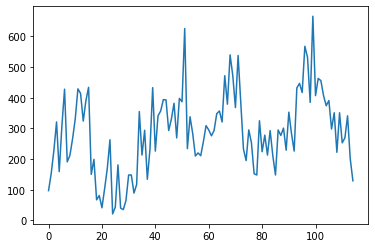

In [5]:
df['IsCanceled'].plot()

In [30]:
dyn_dlm = dlm(df.IsCanceled)
dyn_dlm = dyn_dlm + trend(1, name='lineTrend', w=1.0)
dyn_dlm = dyn_dlm + seasonality(28, name='11wks', w=1.0)
dyn_dlm = dyn_dlm + autoReg(degree=2,  name='ar2', w=1.0)

In [31]:
# introduce dynamic component
features = [[1.0, 2.0] for i in range(115)]
ctrend = dynamic(features = features, name = 'random', discount = 0.9)
dyn_dlm = dyn_dlm + ctrend

In [26]:
dynamic_dlm.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [32]:
dyn_dlm.ls()


The static components are
lineTrend (degree = 2)
11wks (degree = 28)
 
The dynamic components are
random (dimension = 2)
 
The automatic components are
ar2 (dimension = 2)


In [33]:
dyn_dlm.fit()


Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [34]:
dyn_dlm.fitForwardFilter()
dyn_dlm.fitBackwardSmoother()

Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...


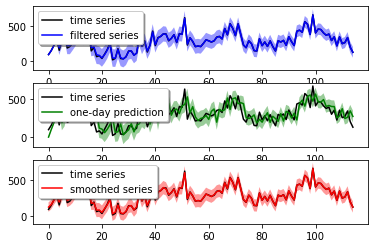

In [35]:
dyn_dlm.turnOff('data points')
dyn_dlm.plot()

In [36]:
dyn_dlm.turnOn('smoothed plot')
dyn_dlm.turnOff('predict')

In [39]:
myTuner = modelTuner(method='gradient_descent', loss='mse')
tunedDLM = myTuner.tune(dyn_dlm, maxit=100)

The algorithm stops without converging.
Possible reason: some discount is too close to 1 or 0.7 (0.7 is smallest discount that is permissible.


In [40]:
dyn_dlm_mse = dyn_dlm.getMSE()
tunedDLM.fit()

In [41]:
dyn_dlm_mse


12105.541458242194

In [42]:
tunedDLM_mse = tunedDLM.getMSE()
tunedDLM_mse

11546.747154615288

In [44]:
np.sqrt(tunedDLM_mse)


107.45579162900103

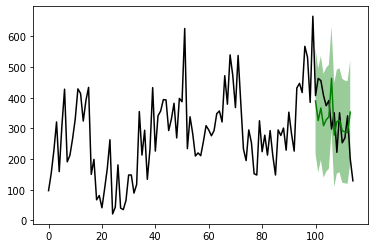

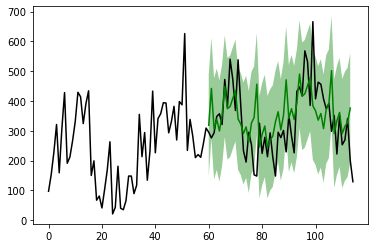

In [45]:
# Plotted prediction for the first 100 weeks, with a forecast generated for the following 14 weeks.
tunedDLM.plotPredictN(date=100, N=14)
# Plotted prediction for the first 60 weeks, with a forecast generated for the following 54 weeks.
tunedDLM.plotPredictN(date=60, N=54)

In [46]:
dyn_pred14=dyn_dlm.predictN(date=100, N=14)
dyn_pred14

([459.31760231324165,
  452.5355455818937,
  486.21152121769165,
  461.13763043075943,
  491.851868525762,
  496.2957807328572,
  575.3547192682832,
  462.3264891846594,
  511.97650723244345,
  546.8289351096322,
  514.4960567224297,
  504.80352729540203,
  526.4151395559171,
  567.8247660513507],
 [83243.11522873428,
  82570.36532741184,
  83229.1822289359,
  83744.9203584958,
  84612.33687182724,
  85303.8074964934,
  86275.43916748984,
  87228.23280637512,
  88958.46425037501,
  89909.78258745286,
  91331.05156943166,
  93238.68066765409,
  94732.04178689481,
  96232.1128059404])

In [49]:
#mean
mean_pred=np.mean(dyn_pred14[0])
print(f'Mean {mean_pred}')
# mse of pred vs test
mse = mean_squared_error(df.IsCanceled[100:114], dyn_pred14[0])
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

Mean 504.09829208730883
RMSE: 195.7300925683024
